In [48]:
# importing necessary packages
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook
import seaborn as sns

In [49]:
# from google.colab import drive
# drive.mount('/content/drive')

In [50]:
# loading dataset
train_csv = pd.read_excel('/kaggle/input/drnoman1000/trainLabels.xlsx')
#test_csv = pd.read_excel('/content/drive/MyDrive/DR_Noman/testLabels.xlsx')

In [51]:
print('Train Size = {}'.format(len(train_csv)))
#print('Test Size = {}'.format(len(test_csv)))

Train Size = 1000


In [52]:
train_csv.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [53]:
#test_csv.head()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


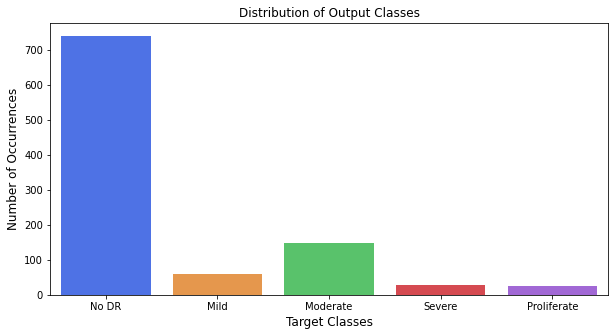

In [54]:
# EDA
counts = train_csv['level'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
sns.barplot(counts.index, counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

In [55]:
#unzipping training data
#from zipfile import ZipFile
#zf = ZipFile('/content/drive/MyDrive/DR_Noman_3000/train.zip', 'r')
#zf.extractall('/content/drive/MyDrive/DR_Noman_3000')
#zf.close()

In [56]:
# image count in training folder
dir_path = r'/kaggle/input/drnoman1000/train/train'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 1000


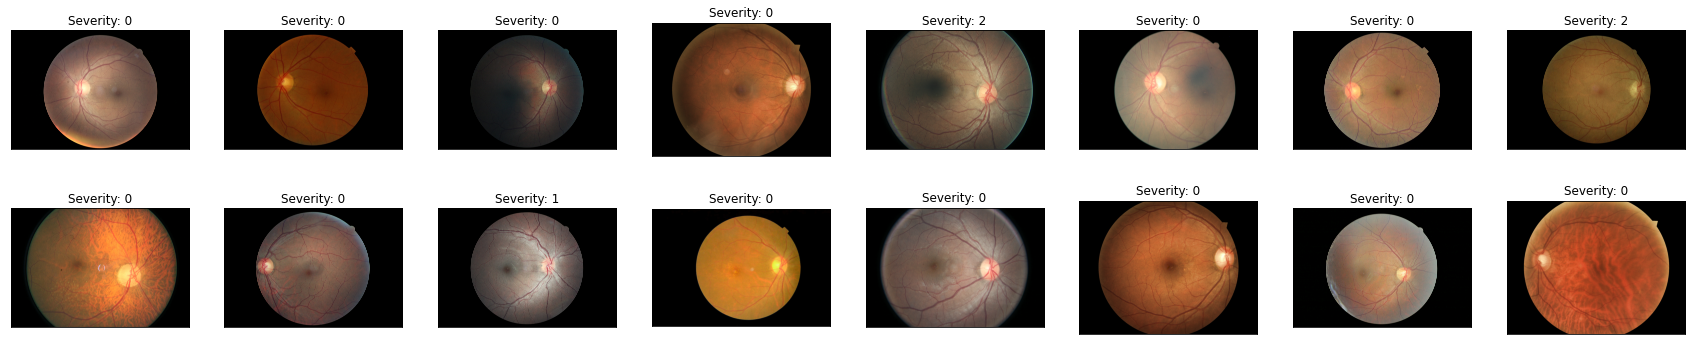

In [57]:
# display 16 images from training set
fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir(dir_path)
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(dir_path + "/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['image'] == img.split('.')[0], 'level'].values[0]
    ax.set_title('Severity: %s'%lab)

In [58]:
#unzipping testing data
#from zipfile import ZipFile
#zf = ZipFile('/content/drive/MyDrive/DR_Noman_Updated/test.zip', 'r')
#zf.extractall('/content/drive/MyDrive/DR_Noman_Updated')
#zf.close()

In [59]:
# image count in testing folder
#dir_path = r'/content/drive/MyDrive/DR_Noman_Updated/test'
#count = 0
# Iterate directory
#for path in os.listdir(dir_path):
    # check if current path is a file
    #if os.path.isfile(os.path.join(dir_path, path)):
        #count += 1
#print('File count:', count)

In [60]:
# display 16 images from testing set
#fig = plt.figure(figsize=(30, 6))
#test_imgs = os.listdir(dir_path)
#for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    #ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    #im = Image.open(dir_path+ "/" + img)
    #plt.imshow(im)

In [61]:
#print(os.listdir("/content/drive/MyDrive"))
base_dir = "/kaggle/input/drnoman1000"

In [62]:
print(os.listdir(base_dir))

['trainLabels.xlsx', 'train']


In [63]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '/kaggle/input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.jpeg')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [64]:
# data augmentation
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [65]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [66]:
train_path = "/kaggle/input/drnoman1000/train/train"
#test_path = "/content/drive/MyDrive/DR_Noman_Updated/test/"

In [67]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
#test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

In [68]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [69]:
num_train

1000

In [70]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [71]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
#testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [72]:
print(f"training examples contain : {len(train_data)}")
#print(f"testing examples contain : {len(test_data)}")

print(f"train loader contain : {len(trainloader)}")
print(f"valid loader contain : {len(validloader)}")
#print(len(trainloader))
#print(len(validloader))
#print(len(testloader))

training examples contain : 1000
train loader contain : 13
valid loader contain : 4


In [73]:
# LOAD ONE BATCH OF Training SET TO CHECK THE IMAGES AND THEIR LABELS
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])


labels: tensor([0, 0, 2, 2, 3, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2,
        2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


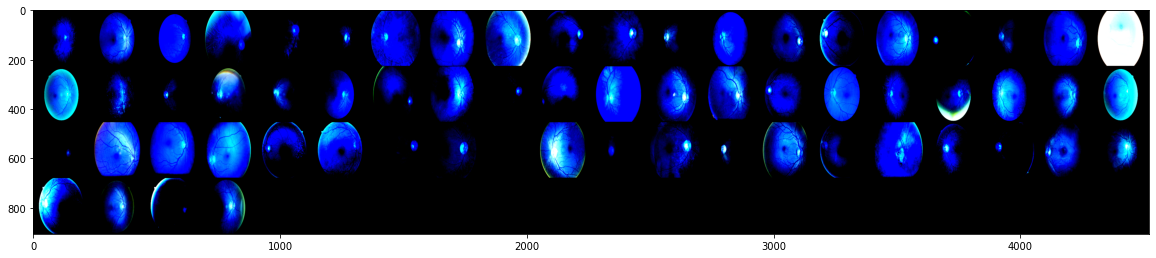

In [74]:
# plotting the images of loaded batch with given fig size and frame data    
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)    

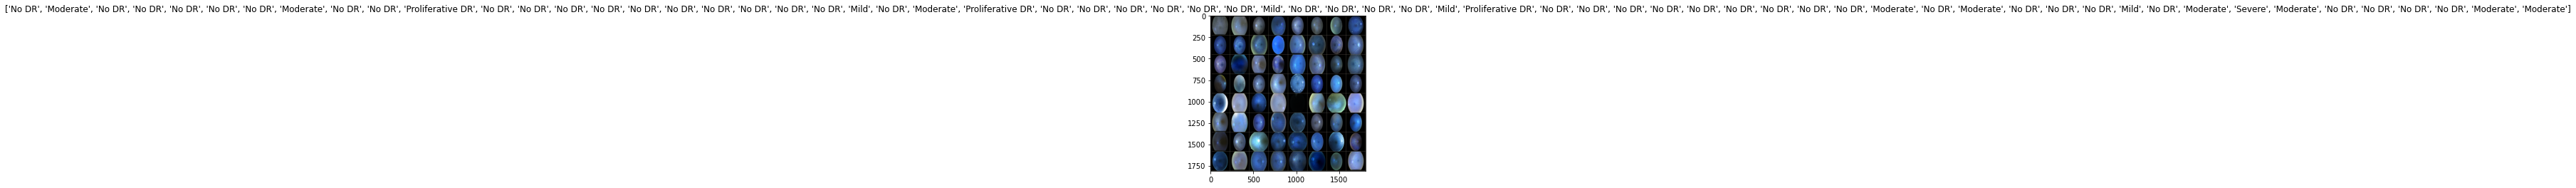

In [75]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [76]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [77]:
# implementing visiontransformer
!pip install -qq einops
!pip install -qq torchsummary

import os
import cv2

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
from tqdm import tqdm

from torch import nn
from torch import Tensor
from torch.utils.data import Subset

from PIL import Image
import pandas as pd
import numpy as np

from torchvision.transforms import Compose, Resize, ToTensor
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

In [78]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size: int=16, 
                 emb_size: int=768, img_size: int=224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, 
                      kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(
                         torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

In [79]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int=768, num_heads: int=8, dropout: float=0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), 
                        "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        # batch, num_heads, query_len, key_len
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [80]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [81]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int=4, drop_p: float=0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [82]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [83]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int=12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [84]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int=768, n_classes: int=1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [85]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 5,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [86]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = ViT().to(device)

In [87]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [88]:
model

ViT(
  (0): PatchEmbedding(
    (projection): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (1): Rearrange('b e (h) (w) -> b (h w) e')
    )
  )
  (1): TransformerEncoder(
    (0): TransformerEncoderBlock(
      (0): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (att_drop): Dropout(p=0, inplace=False)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (2): Dropout(p=0.0, inplace=False)
        )
      )
      (1): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (1): FeedForwardBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU()
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_fea

In [89]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
85802501


In [90]:
torch.save(model.state_dict(), 'DR_classifier_Noman_VisionTransformer.pth')

In [91]:
path = "/kaggle/working/DR_classifier_Noman_VisionTransformer.pth"
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [92]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [93]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses, acc = [] , [], []
    valid_loss_min = np.Inf 
    model.train()
    print("Model Training started.....")
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 10 == 0:
            print(f" epoch {epoch + 1} batch {batch} completed") 
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        print(f"validation started for {epoch + 1}")
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          test_loss += criterion(logps,labels) 
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      acc.append(accuracy)
      scheduler.step()
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train() 
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)    
    print('Training Completed Succesfully !')    
    return train_losses, test_losses, acc 

In [94]:
import time
t0 = time.time()
train_losses, valid_losses, acc = train_and_test(10)
print("Training time:", time.time()-t0)

Model Training started.....
 epoch 1 batch 10 completed
validation started for 1
Epoch: 1/10..  Training Loss: 1.172..  Valid Loss: 0.987..  Valid Accuracy: 0.781
Validation loss decreased (inf --> 0.986557).  Saving model ...
 epoch 2 batch 10 completed
validation started for 2
Epoch: 2/10..  Training Loss: 0.924..  Valid Loss: 0.857..  Valid Accuracy: 0.758
Validation loss decreased (0.986557 --> 0.857115).  Saving model ...
 epoch 3 batch 10 completed
validation started for 3
Epoch: 3/10..  Training Loss: 0.894..  Valid Loss: 0.861..  Valid Accuracy: 0.730
 epoch 4 batch 10 completed
validation started for 4
Epoch: 4/10..  Training Loss: 0.879..  Valid Loss: 0.699..  Valid Accuracy: 0.812
Validation loss decreased (0.857115 --> 0.698851).  Saving model ...
 epoch 5 batch 10 completed
validation started for 5
Epoch: 5/10..  Training Loss: 0.877..  Valid Loss: 0.895..  Valid Accuracy: 0.758
 epoch 6 batch 10 completed
validation started for 6
Epoch: 6/10..  Training Loss: 0.868..  Val

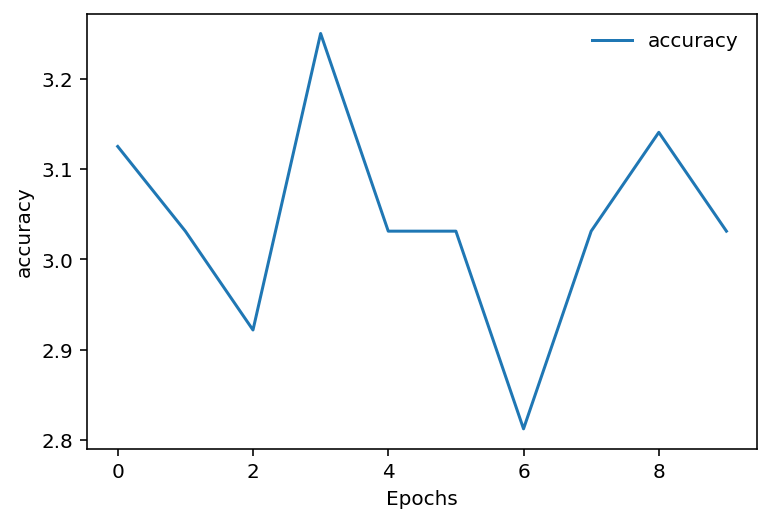

In [95]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(acc, label='accuracy')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(frameon=False)

In [96]:
# epochs = 5

# epoch_losses = np.zeros((epochs, len(trainloader)))
# epoch_accuracies = np.zeros((epochs, len(trainloader)))

# epoch_val_losses = np.zeros((epochs, len(validloader)))
# epoch_val_accuracies = np.zeros((epochs, len(validloader)))

# print("Model Training started.....")
# for epoch in range(epochs):
    
#     for i, (data, label) in enumerate(trainloader):
#         data = data.to(device)
#         label = label.to(device)
        
#         output = model(data)
#         loss = criterion(output, label)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         acc = (output.argmax(dim=1) == label).float().mean()
#         epoch_accuracies[epoch][i] = acc
        
#         epoch_loss = loss / len(data)
#         epoch_losses[epoch][i] = epoch_loss
        
#     with torch.no_grad():

#         for i, (data, label) in enumerate(validloader):
#             data = data.to(device)
#             label = label.to(device)
            
#             val_output = model(data)
#             val_loss = criterion(val_output, label)
            
#             acc = (val_output.argmax(dim=1) == label).float().mean()
#             epoch_val_accuracies[epoch][i] = acc
            
#             epoch_val_loss = val_loss / len(data)
#             epoch_val_losses[epoch][i] = epoch_val_loss
           
#         #if((epoch+1) % 2 == 0):
#     print("Epoch:{:3d}, Training loss:{:.4f}, Training acc:{:.4f}, val_loss:{:.4f}, val_acc:{:.4f}"
#                   .format(epoch, epoch_losses[epoch].mean(), 
#                           epoch_accuracies[epoch].mean(), 
#                           epoch_val_losses[epoch].mean(), 
#                           epoch_val_accuracies[epoch].mean()))
#     torch.save({
#         'epoch': epochs,
#         'model': model,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict()
#         #'loss': valid_loss_min
#         }, path)
# print('Training Completed Succesfully !')  
# import time
# t0 = time.time()
# print("Training time:", time.time()-t0)

In [97]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
# axes[0,0].set_title('Training Losses', color='blue')
# axes[0,0].plot(epoch_losses.mean(axis=1))
# axes[0,0].axes.get_xaxis().set_visible(False)
# axes[0,1].set_title('Validation Losses', color='blue')
# axes[0,1].plot(epoch_val_losses.mean(axis=1))
# axes[0,1].axes.get_xaxis().set_visible(False)
# axes[1,0].set_title('Training Accuracy', color='orange')
# axes[1,0].plot(epoch_accuracies.mean(axis=1), color='orange')
# axes[1,0].axes.get_xaxis().set_visible(False)
# axes[1,1].set_title('Validation Accuracy', color='orange')
# axes[1,1].plot(epoch_val_accuracies.mean(axis=1), color='orange')
# axes[1,1].axes.get_xaxis().set_visible(False)
# fig.tight_layout()

In [98]:
# def predict(image, device):
#     if len(image.shape) == 3:
#         image = image.unsqueeze(0)
        
#     label = model(image.to(device))
#     label_max = torch.max(label, axis=1)[1].item()
#     return label_max

In [99]:
# c = 0
# for i in range(len(train_data)):
#     image, label = train_data[i]
    
#     predicted = predict(image, device)
#     expected = label
#     correct = expected==predicted
    
#     print('{:2d}) Expected:{:1d} - Predicted:{:1d} - Correct:{}'
#              .format(i+1, expected, predicted, correct))
#     if correct == True:
#         c += 1
#     print("Total Correct: ", c)